## Solucion del proyecto: Vender 100 mil copias de un video juego
### Módulo 4 - Big Data
### Estudidante: Yoksan Varela Cambronero

### Primera parte: Carga del set de datos desde POSTGRESQL DB
A continuacion se hace una carga en limpio del set de datos almacenado en la base de datos. El nombre de la base de datos es *video_games_ml_ready*:

In [5]:
# Librerias generales
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
# Iniciando la sesion de Spark
import findspark # type: ignore
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Video Games Spark Session") \
    .config("spark.driver.extraClassPath", "postgresql-42.7.3.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.7.3.jar") \
    .getOrCreate()

ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/14 01:42:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [2]:
# Carga de la base de datos de POSTGRESQL
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "video_games_ml_ready") \
    .load()

df.printSchema()
df.show()

root
 |-- game_title: string (nullable = true)
 |-- console: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- genre: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- user_score: float (nullable = true)
 |-- total_sales: float (nullable = true)

+--------------------+-------+--------------------+------------+---------------+--------------------+----------+-----------+
|          game_title|console|           publisher|release_date|          genre|              rating|user_score|total_sales|
+--------------------+-------+--------------------+------------+---------------+--------------------+----------+-----------+
|   super bust-a-move|    gba|             ubisoft|  2000-11-26|matching puzzle|rated e for everyone|  6.894852|       0.05|
|   super bust-a-move|    ps2|acclaim entertain...|  2000-11-26|matching puzzle|rated e for everyone|  6.894852|       0.34|
|                tmnt|     ds|             ubis

In [4]:
# Confirmando que no haya NaN or Nulls
from pyspark.sql.functions import col, sum

nan_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
nan_counts.show()

+----------+-------+---------+------------+-----+------+----------+-----------+
|game_title|console|publisher|release_date|genre|rating|user_score|total_sales|
+----------+-------+---------+------------+-----+------+----------+-----------+
|         0|      0|        0|           0|    0|     0|         0|          0|
+----------+-------+---------+------------+-----+------+----------+-----------+



In [25]:
num_rows = df.count()
num_columns = len(df.columns)
print(f"Dimensiones del dataframe: ({num_rows}, {num_columns})")

Dimensiones del dataframe: (8593, 8)


Ya con el set de datos cargados, se procede a hacer una analisis preliminar de los datos para entender los atributos y su relacion con la variable de salida. De primera entrada, se empieza con la creacion del objetivo predictivo:

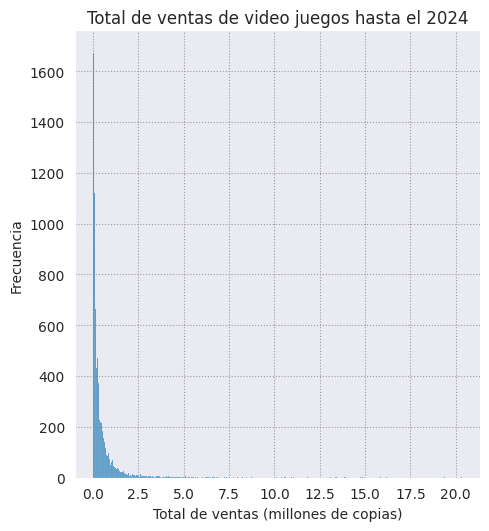

In [6]:
# Analizando el balanceo en el objetivo predictivo
# Estilo de Seaborn
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# Hacer collect de la variable predictiva
df_vg_sales = df.select('total_sales').rdd.flatMap(lambda x: x).collect()

sns.displot(data=df_vg_sales, kde=False)
plt.xlabel('Total de ventas (millones de copias)')
plt.ylabel('Frecuencia')
plt.title('Total de ventas de video juegos hasta el 2024')
plt.show()

Hay una cantidad de juegos que se han vendido mucho, lo cual genera esa cola larga hacia la derecha. Haciendo un analisis mas enfocado cerca del punto de interes de las 100 mil copias vendidas:

In [9]:
# Filtrando el set de datos por los menos de un millon de copias vendidas
df_vg_sales_filtered = df.filter(df['total_sales'] < 1)
num_rows = df_vg_sales_filtered.count()
num_columns = len(df_vg_sales_filtered.columns)

# Imprimiendo informacion del set de datos filtrado
print(f"Dimensiones del dataframe: ({num_rows}, {num_columns})")
df_vg_sales_filtered.show()

Dimensiones del dataframe: (7514, 8)
+--------------------+-------+--------------------+------------+---------------+--------------------+----------+-----------+
|          game_title|console|           publisher|release_date|          genre|              rating|user_score|total_sales|
+--------------------+-------+--------------------+------------+---------------+--------------------+----------+-----------+
|   super bust-a-move|    gba|             ubisoft|  2000-11-26|matching puzzle|rated e for everyone|  6.894852|       0.05|
|   super bust-a-move|    ps2|acclaim entertain...|  2000-11-26|matching puzzle|rated e for everyone|  6.894852|       0.34|
|                tmnt|     ds|             ubisoft|  2007-03-20| 3d beat-'em-up|rated e +10 for e...|       5.9|       0.04|
|                tmnt|    psp|             ubisoft|  2007-03-20| 3d beat-'em-up|rated e +10 for e...|       5.9|       0.11|
|                tmnt|    wii|             ubisoft|  2007-03-20| 3d beat-'em-up|rated e 

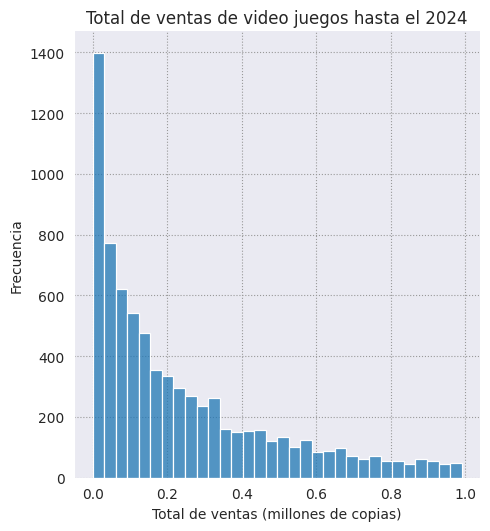

In [10]:
# Analizando mas cerca del punto de interes
df_vg_sales_less_1m = df_vg_sales_filtered.select('total_sales').rdd.flatMap(lambda x: x).collect()

sns.displot(data=df_vg_sales_less_1m, kde=False)
plt.xlabel('Total de ventas (millones de copias)')
plt.ylabel('Frecuencia')
plt.title('Total de ventas de video juegos hasta el 2024')
plt.show()

Las ventas totales siguen una distribucion lognormal. Ahora se crea un lable nuevo en donde la cantidad de ventas totales haya sido mayor a las 100 mil copias.

In [22]:
# Creando el label, siendo la variable predictiva
from pyspark.sql.functions import when

df_videogames_sales_target = df.withColumn("label", when(df["total_sales"] > 0.1, "Yes").otherwise("No"))
df_videogames_sales_target.show()

+--------------------+-------+--------------------+------------+---------------+--------------------+----------+-----------+-----+
|          game_title|console|           publisher|release_date|          genre|              rating|user_score|total_sales|label|
+--------------------+-------+--------------------+------------+---------------+--------------------+----------+-----------+-----+
|   super bust-a-move|    gba|             ubisoft|  2000-11-26|matching puzzle|rated e for everyone|  6.894852|       0.05|   No|
|   super bust-a-move|    ps2|acclaim entertain...|  2000-11-26|matching puzzle|rated e for everyone|  6.894852|       0.34|  Yes|
|                tmnt|     ds|             ubisoft|  2007-03-20| 3d beat-'em-up|rated e +10 for e...|       5.9|       0.04|   No|
|                tmnt|    psp|             ubisoft|  2007-03-20| 3d beat-'em-up|rated e +10 for e...|       5.9|       0.11|  Yes|
|                tmnt|    wii|             ubisoft|  2007-03-20| 3d beat-'em-up|rat

Dimensiones del dataframe: (8593, 9)


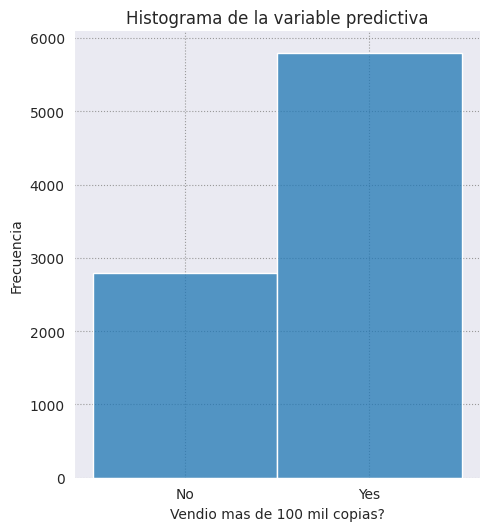

In [24]:
# Analizando el label
df_vg_sales_label = df_videogames_sales_target.select('label').rdd.flatMap(lambda x: x).collect()

# Algunas metricas del set de datos con el label de interes
num_rows = df_videogames_sales_target.count()
num_columns = len(df_videogames_sales_target.columns)
print(f"Dimensiones del dataframe: ({num_rows}, {num_columns})")

sns.displot(data=df_vg_sales_label, kde=False)
plt.xlabel('Vendio mas de 100 mil copias?')
plt.ylabel('Frecuencia')
plt.title('Histograma de la variable predictiva')
plt.show()